In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv("../.env")

True

In [2]:
import json
import os

import matplotlib.pyplot as plt
import mlflow
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.notebook import tqdm

from such_toxic.text_classifier import TextClassifier

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [4]:
embedded_dataset_path = "../target/wiki_data_all_human_all_mini.json"

sentence_transformer_model = "sentence-transformers/all-MiniLM-L6-v2"
experiment_name = "such-toxic"
model_name = "such_toxic"

num_classes = 6
batch_size = 32
epochs = 15
lr = 0.001

In [5]:
if os.getenv("MLFLOW_ENABLED") == "true":
    print("Starting run")
    mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
    mlflow.set_experiment("such-toxic")
    mlflow.pytorch.autolog()
    mlflow.start_run()

    mlflow.log_param("model_name", model_name)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("learning_rate", lr)

2024/03/20 23:57:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/03/20 23:57:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run


In [6]:
with open(embedded_dataset_path) as f:
    dataset = json.loads(f.read())

if os.getenv("MLFLOW_ENABLED") == "true":
    mlflow.log_artifact(embedded_dataset_path)

In [7]:
class SuchToxicDataset(Dataset):
    def __init__(self, rows):
        self.rows = rows

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        row = self.rows[idx]
        labels = torch.tensor(
            [
                row["toxic"],
                row["severe_toxic"],
                row["obscene"],
                row["threat"],
                row["insult"],
                row["identity_hate"],
            ],
            dtype=torch.float32,
        )
        embedding = torch.tensor(row["embedding"])
        return embedding, labels


train, test = random_split(dataset, [0.8, 0.2])

train_dataset = SuchToxicDataset(list(train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for batch in train_loader:
    print("embedding: ", batch[0].shape)
    print("labels: ", batch[1].shape)
    break

embedding:  torch.Size([32, 384])
labels:  torch.Size([32, 6])


In [8]:
loss_fn = torch.nn.BCELoss()
model = TextClassifier(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

TextClassifier(
  (linear): Linear(in_features=384, out_features=6, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
losses = []

pbar = tqdm(range(epochs), desc="Epoch")
for epoch in pbar:
    total_loss = 0.0
    for embedding, labels in train_loader:
        optimizer.zero_grad()
        embedding = embedding.squeeze(1).to(device)
        labels = labels.to(device)

        prediction = model(embedding)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    pbar.set_postfix(loss=avg_loss)

    if os.getenv("MLFLOW_ENABLED") == "true":
        mlflow.log_metric("loss", avg_loss, step=epoch)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

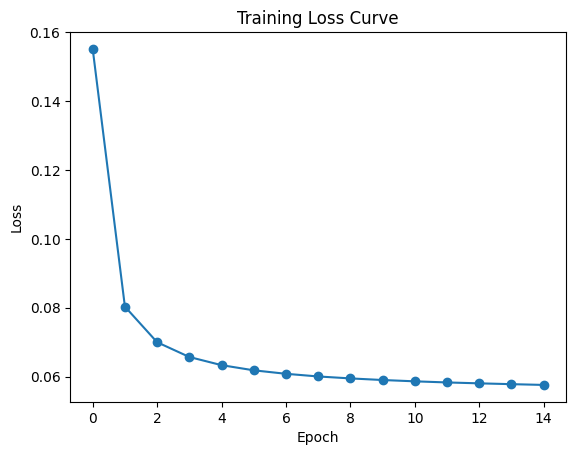

In [10]:
plt.plot(losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.savefig("../target/training_loss.png")

In [11]:
torch.save(
    {
        "epoch": epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": losses[-1],
    },
    f"../checkpoints/{model_name}.pth",
)

if os.getenv("MLFLOW_ENABLED") == "true":
    mlflow.pytorch.log_model(model, "such-toxic")

In [12]:
def accuracy(y_true, y_pred, threshold=0.8):
    labels = 0
    for true, pred in zip(y_true, y_pred):
        pred = 1 if pred >= threshold else 0
        if true == pred:
            labels += 1
    return labels / len(y_true)

In [13]:
total_accuracy = 0
for row in list(test):
    embedding = torch.tensor([row["embedding"]]).to(device)
    label = [
        row["toxic"],
        row["severe_toxic"],
        row["obscene"],
        row["threat"],
        row["insult"],
        row["identity_hate"],
    ]

    output = model(embedding)
    output = output.cpu().detach().numpy().tolist()[0]
    total_accuracy += accuracy(label, output)

print(total_accuracy / len(test))

0.976065885400333


In [14]:
sentence_transformer = SentenceTransformer(sentence_transformer_model)

if os.getenv("MLFLOW_ENABLED") == "true":
    data = "Hello world!"
    signature = mlflow.models.infer_signature(
        model_input=data,
        model_output=sentence_transformer.encode(data),
    )
    mlflow.sentence_transformers.log_model(
        model=sentence_transformer,
        artifact_path=sentence_transformer_model,
        signature=signature,
        input_example=data,
    )

/tmp/ipykernel_2606729/334983547.py:9: FutureWarning: The 'sentence_transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``2.2.2`` -  ``2.4.0``. MLflow Models integrations with sentence_transformers may not succeed when used with package versions outside of this range.
  mlflow.sentence_transformers.log_model(
/home/nish/Developer/such-toxic/.venv/lib/python3.10/site-packages/mlflow/models/model.py:619: FutureWarning: The 'sentence_transformers' MLflow Models integration is known to be compatible with the following package version ranges: ``2.2.2`` -  ``2.4.0``. MLflow Models integrations with sentence_transformers may not succeed when used with package versions outside of this range.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
/home/nish/Developer/such-toxic/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptoo

In [15]:
test_str = "What a bunch of fucking nerds..."


embedding = sentence_transformer.encode([test_str], convert_to_tensor=True)
output = model(embedding)
output = output.cpu().detach().numpy().tolist()[0]

print("Toxic: ", output[0])
print("Severe Toxic: ", output[1])
print("Obscene: ", output[2])
print("Threat: ", output[3])
print("Insult: ", output[4])
print("Identity Hate: ", output[5])

Toxic:  0.9951565861701965
Severe Toxic:  0.1802455186843872
Obscene:  0.9900761246681213
Threat:  0.0018481726292520761
Insult:  0.9670491814613342
Identity Hate:  0.058093372732400894


In [16]:
if os.getenv("MLFLOW_ENABLED") == "true":
    mlflow.end_run()

2024/03/21 00:02:25 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/21 00:02:25 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
